## 1. Import Dependancies

In [1]:
import pandas as pd                                             # pandas==1.4.1
import numpy as np                                              # numpy==1.21.5
from matplotlib import pyplot as plt                            # matplotlib==3.5.1
import seaborn as sns                                           # seaborn==0.11.2
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler   # scikit-learn==1.0.2
from sklearn.exceptions import NotFittedError
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import cross_val_score
from random import seed, random

## 2. Import Data
- Data is a .txt file, however, its structure is similar to a .csv but with spaces as delimiters instead of commas.
- We can use the pandas.read_csv method to import it as a dataframe object.

In [2]:
# Import data and assign column names
data_fpath = '../data/GSOC_Data_DataCube.txt'
colnames_observable = ['od','od_uncertainty','max_ev','max_ev_uncertainty','flux300']
colnames_physical = ['mass_total','mass_Ni','energy','mass_distribution','radial_distribution']
df = pd.read_csv(data_fpath, sep=' ', names=colnames_observable+colnames_physical)
df.head()

,od,od_uncertainty,max_ev,max_ev_uncertainty,flux300,mass_total,mass_Ni,energy,mass_distribution,radial_distribution
0,1.940628,0.179354,0.013531,0.000670,0.000003,0.75,0.15,0.75,hed8,hed8
1,2.071999,0.210287,0.012423,0.000615,0.000003,0.75,0.15,0.75,hed8,mwd
2,2.007982,0.198804,0.012744,0.000685,0.000003,0.75,0.15,0.75,hed8,N100
3,1.661535,0.189436,0.009935,0.000349,0.000003,0.75,0.15,0.75,hed8,w7dt
4,1.907672,0.178607,0.013343,0.000745,0.000003,0.75,0.15,2.00,hed8,hed8


In [3]:
# Creating a mapped dictionary of units
units = dict(zip(colnames_observable,['','','s⁻¹','s⁻¹','cm⁻²s⁻¹']))
units.update(dict(zip(colnames_physical,['M☉','M☉','10⁵¹ ergs','',''])))
units

{'od': '',
 'od_uncertainty': '',
 'max_ev': 's⁻¹',
 'max_ev_uncertainty': 's⁻¹',
 'flux300': 'cm⁻²s⁻¹',
 'mass_total': 'M☉',
 'mass_Ni': 'M☉',
 'energy': '10⁵¹ ergs',
 'mass_distribution': '',
 'radial_distribution': ''}

In [4]:
# Check columns for missing values and data-type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   od                   512 non-null    float64
 1   od_uncertainty       512 non-null    float64
 2   max_ev               512 non-null    float64
 3   max_ev_uncertainty   512 non-null    float64
 4   flux300              512 non-null    float64
 5   mass_total           512 non-null    float64
 6   mass_Ni              512 non-null    float64
 7   energy               512 non-null    float64
 8   mass_distribution    512 non-null    object 
 9   radial_distribution  512 non-null    object 
dtypes: float64(8), object(2)
memory usage: 40.1+ KB


- No missing data present.
- Columns 1 through 8 are numerical; 9 and 10 are strings.
- 512 data points is limited, we might need to find a way to upsample the dataset.

## 3. Exploratory Data Analysis

### 3.1. Step 1 - Observable Parameters (Input Features)

In [5]:
# Show column statistics since all observable parameters are numerical data
df_obs = df.loc[:,colnames_observable]
df_obs.describe().iloc[1:]

,od,od_uncertainty,max_ev,max_ev_uncertainty,flux300
mean,2.576275,0.198927,0.012814,0.000512,0.000007
std,0.391005,0.021055,0.000849,0.000074,0.000004
min,1.661535,0.133992,0.009842,0.000313,0.000003
25%,2.321794,0.183659,0.012372,0.000458,0.000003
50%,2.559251,0.198672,0.012891,0.000501,0.000006
75%,2.812090,0.215768,0.013388,0.000556,0.000011
max,3.621963,0.239162,0.014723,0.000817,0.000015


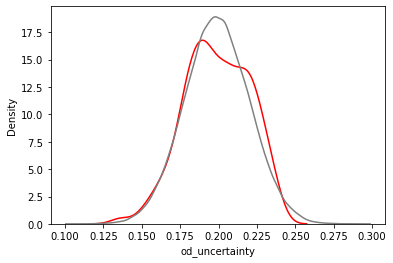

In [6]:
# Distribution of uncertainties of optical depth compared to a normal distribution
fig, ax = plt.subplots()
sns.kdeplot(df_obs.od_uncertainty,ax=ax,color='red')
normal = np.random.normal(loc=df_obs.od_uncertainty.mean(),\
    scale=df_obs.od_uncertainty.std(),size=10**5)
sns.kdeplot(normal,ax=ax,color='grey')
plt.show()

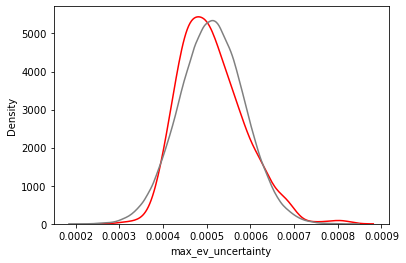

In [7]:
# Distribution of uncertainties of maximum expansion velocity compared to a normal distribution
fig, ax = plt.subplots()
sns.kdeplot(df_obs.max_ev_uncertainty,ax=ax,color='red')
normal = np.random.normal(loc=df_obs.max_ev_uncertainty.mean(),\
    scale=df_obs.max_ev_uncertainty.std(),size=10**5)
sns.kdeplot(normal,ax=ax,color='grey')
plt.show()

In [8]:
# Obtain the relative uncertainties of optical depth
od_uncertainty_pct = df_obs.od_uncertainty / df_obs.od
od_uncertainty_pct.describe().iloc[1:]

mean    0.078545
std     0.011796
min     0.047808
25%     0.069775
50%     0.078088
75%     0.086126
max     0.114326
dtype: float64

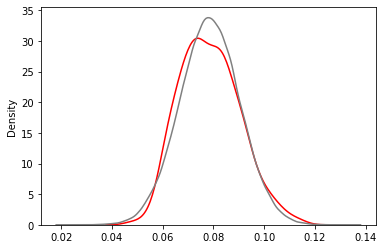

In [9]:
# Distribution of relative uncertainties of optical depth compared to a normal distribution
fig, ax = plt.subplots()
sns.kdeplot(od_uncertainty_pct,ax=ax,color='red')
normal = np.random.normal(loc=od_uncertainty_pct.mean(),\
    scale=od_uncertainty_pct.std(),size=10**5)
sns.kdeplot(normal,ax=ax,color='grey')
plt.show()

In [10]:
# Obtain the relative uncertainties of maximum expansion velocity compared to a normal distribution
max_ev_uncertainty_pct = df_obs.max_ev_uncertainty / df_obs.max_ev
max_ev_uncertainty_pct.describe().iloc[1:]

mean    0.039927
std     0.005138
min     0.026519
25%     0.036309
50%     0.039165
75%     0.042926
max     0.063529
dtype: float64

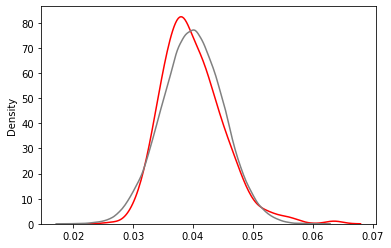

In [11]:
# Distribution of relative uncertainties of maximum expansion velocity
fig, ax = plt.subplots()
sns.kdeplot(max_ev_uncertainty_pct,ax=ax,color='red')
normal = np.random.normal(loc=max_ev_uncertainty_pct.mean(),\
    scale=max_ev_uncertainty_pct.std(),size=10**5)
sns.kdeplot(normal,ax=ax,color='grey')
plt.show()

- The maximum relative uncertainty for optical depth is 11.4% and is normally distributed.
    - mean=0.078545, std=0.011796
- The maximum relative uncertainty for the maximum expansion velocity is 6.4% and is normally distributed.
    - mean=0.039927, std=0.005138
- From the above 4 plots, we can see that for uncertainties, both the absolute and relative uncertainty have a similar percent of standard deviation. This shows that the measurement instruments used to measure optical depth and maximum expansion velocity has both:
    - Instrumental Errors (due to its own measurement error), and 
    - Environmental Errors (due to the magnitude of what its measuring. ie, the larget the optical depth, the larger the uncertainty)

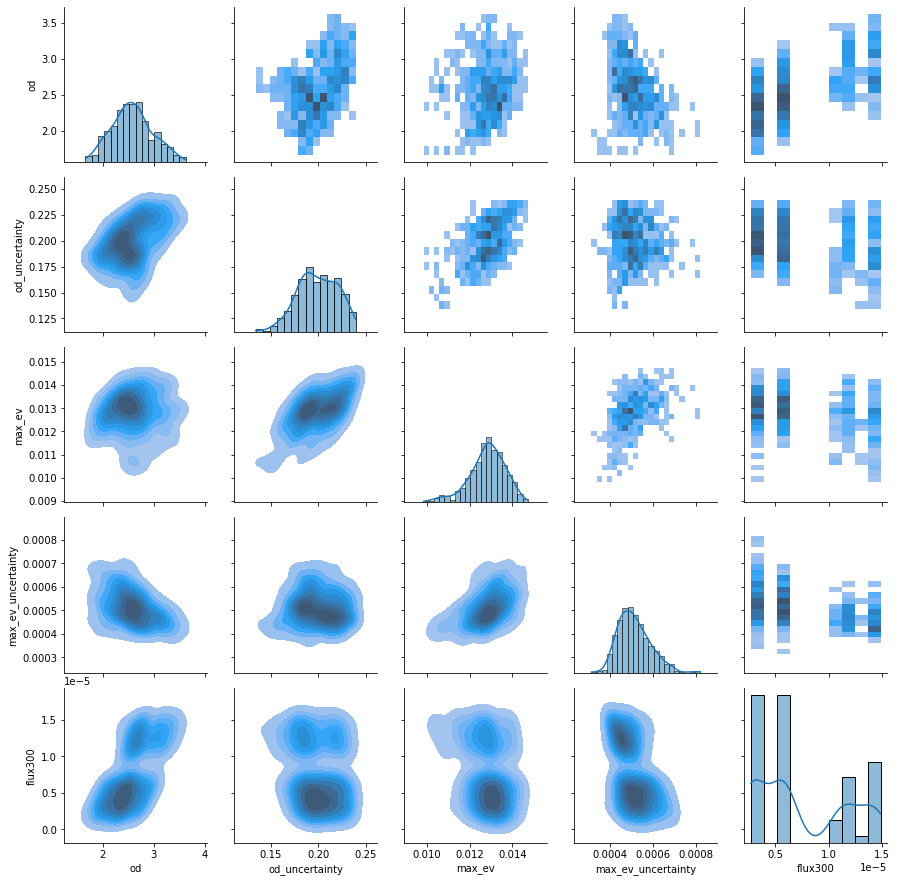

In [12]:
# Pairplot
g = sns.PairGrid(df_obs)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)
plt.show()

- Data for optical depth and maximum expansion velocity seems to be normally distributed. 
- The histogram for emergent flux seems to be missing alot of bins. 
- Uncertainties of optical depth and maximum expansion velocity seems to be positively correlated. Which further suggests the measurement instruments environmental error.
- Optical depth and flux seems to be positively correlated.
- Maximum expansion velocity and flux seems to have little relation. 
- Maximum expansion velocity and optical depth seems to have little relation. 

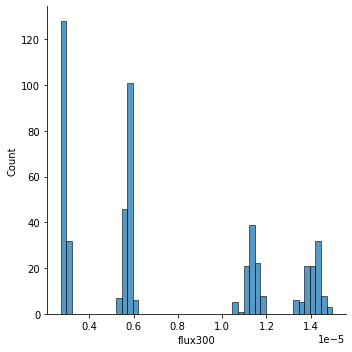

In [13]:
# Examine flux data
sns.displot(df_obs.flux300, binwidth=2.5e-7)
plt.show()

- Flux values seem to have 4 distinct bins:
    - 0.1e-5 to 0.3e-5
    - 0.5e-5 to 0.65e-5
    - 1.0e-5 to 1.2e-5
    - 1.3e-5 to 1.6e-5
- We can consider splitting these into 4 categories between the following values: [0, 0.4e-5, 0.85e-5, 1.25e-5, 1.6e-5]

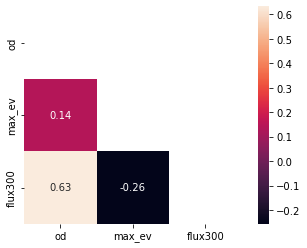

In [14]:
# Pearsons correlation heatmap of features
corr = df_obs.iloc[:,[0,2,4]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, square=True, annot=True)
plt.show()

- Since flux is highly positively correlated to optical depth, and moderately negatively correlated to maximum expansion velocity, converting flux to a categorical feature might aid in preventing multicollinearity of our features.

### 3.2. Step 2 - Physical Parameters (Target Features)

In [15]:
# Show column statistics since all physical parameters that are numerical
df_phy = df.loc[:,colnames_physical]
df_phy.describe().iloc[1:]

,mass_total,mass_Ni,energy
mean,1.518750,0.393750,1.375000
std,0.434834,0.230629,0.625611
min,0.750000,0.150000,0.750000
25%,1.300000,0.150000,0.750000
50%,1.600000,0.300000,1.375000
75%,1.850000,0.600000,2.000000
max,2.000000,0.750000,2.000000


In [16]:
# Counts of mass distributions
df_phy.mass_distribution.value_counts()

hed8    128
mwd     128
N100    128
w7dt    128
Name: mass_distribution, dtype: int64

In [17]:
# Counts of radial distributions
df_phy.radial_distribution.value_counts()

hed8    128
mwd     128
N100    128
w7dt    128
Name: radial_distribution, dtype: int64

In [18]:
# Counts of mass and radial distribution permutations
distribution_flags = df_phy.mass_distribution+'-'+df_phy.radial_distribution
distribution_flags.value_counts()

hed8-hed8    32
hed8-mwd     32
hed8-N100    32
hed8-w7dt    32
mwd-hed8     32
mwd-mwd      32
mwd-N100     32
mwd-w7dt     32
N100-hed8    32
N100-mwd     32
N100-N100    32
N100-w7dt    32
w7dt-hed8    32
w7dt-mwd     32
w7dt-N100    32
w7dt-w7dt    32
dtype: int64

- It seems that there are 32 points of data for each possible permutation of distribution.
- Therefore, we shall next find out how the mass and radial distributions correlate to our numerical data distributions.

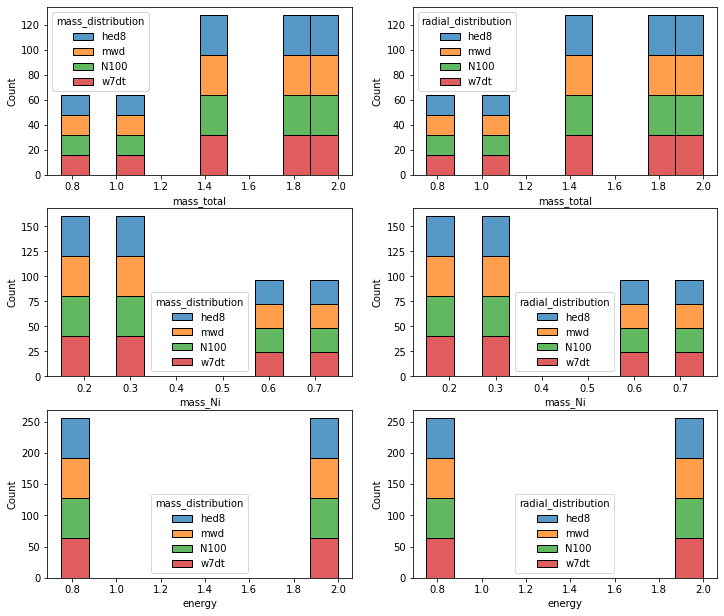

In [19]:
fig, axs = plt.subplots(3,2)
fig.set_size_inches(12, 10.5)
for i, num_col in enumerate(df_phy.columns[:3]):
    for j, cat_col in enumerate(df_phy.columns[3:]):
        sns.histplot(data=df_phy,x=num_col,hue=cat_col,multiple="stack",ax=axs[i,j])
plt.show()

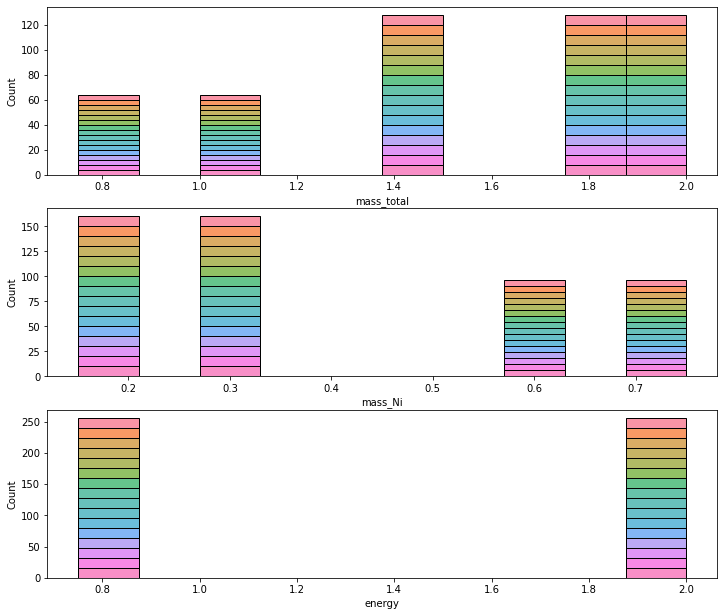

In [20]:
fig, axs = plt.subplots(3,1)
fig.set_size_inches(12, 10.5)
for i, num_col in enumerate(df_phy.columns[:3]):
    sns.histplot(data=df_phy,x=num_col,hue=distribution_flags,multiple="stack",ax=axs[i],legend=False)
plt.show()

- It seems like the mass and radial distributions are evenly split into our numerical target data.
- I suspect that our numerical data is categorical, lets check.

In [21]:
for col in df_phy.columns[:3]:
    print(f'{col}:','value\tcount',df_phy[col].value_counts(),sep='\n',end="\n\n")

mass_total:
value	count
1.40    128
1.80    128
2.00    128
0.75     64
1.00     64
Name: mass_total, dtype: int64

mass_Ni:
value	count
0.15    160
0.30    160
0.60     96
0.75     96
Name: mass_Ni, dtype: int64

energy:
value	count
0.75    256
2.00    256
Name: energy, dtype: int64



- The numerical columns in our physical data is indeed categorical, these can be transformed into ordinal data for further analysis.
    - There are 5 distinct values for total mass.
    - There are 4 distinct values for nickel mass.
    - There are 2 distinct values for energy.
- For the categorical columns:
    - There are 2 distinct categories for the mass distribution flag.
    - There are 2 distinct categories for the radial distribution flag.

Next, we will check the distinct combinations in our dataset versus the possible combinations with these categories.

In [22]:
# Get the number of distinct permutions in the target dataset
distinct = len(df_phy.value_counts())
possible = np.prod([len(df_phy[x].unique()) for x in df_phy.columns])
print(f'The number of distinct permutions is {distinct}.')
print(f'The number of possible permutions is {possible}.')

The number of distinct permutions is 512.
The number of possible permutions is 640.


- This means that there are some combinations of our target features which are either:
    1. Not available for in our target dataset.
    2. Not possible or cannot exist.
- Either way, we will have to train and predict for individual physical targets in order to get a possible prediction on a non-existent target permutation.

### 3.3. Step 2 - Connection Between Observable and Physical Parameters 

- Lets have a quick look at the relationship between all parameters
- A quick way is to generate a pair plot and a correlation matrix.

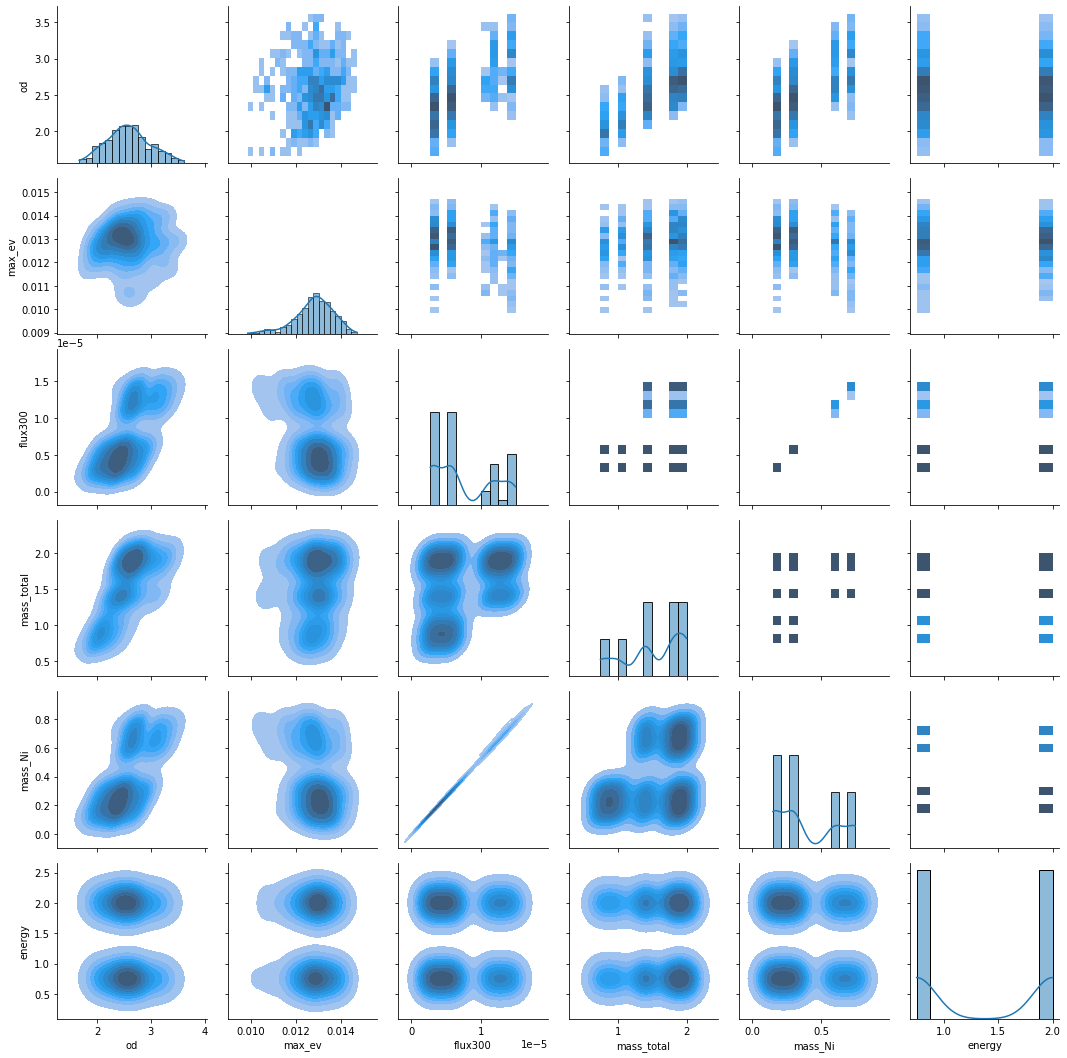

In [23]:
# Pair plot
g = sns.PairGrid(df.iloc[:,[0,2,4,5,6,7]])
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)
plt.show()

- From the pair plot, the most noticable relationships for each physical parameters are:
    - Flux and nickel mass, it is highly positively and linearly correlated. 
    - OD and total mass, seems to be moderately correlated.
    - Energy does not seem correlated to any observable feature. However, it is hard to visualize as there are only 2 values for energy.
- Lets look at the correlation matrix.

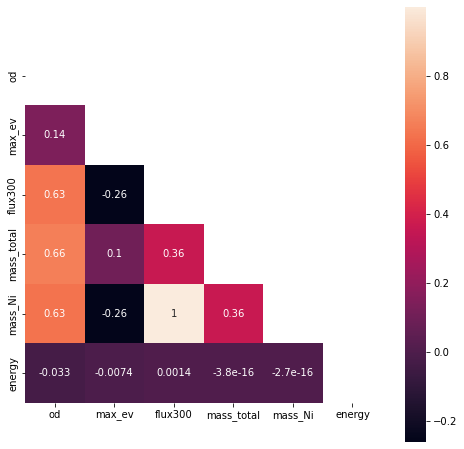

In [24]:
# Pearsons correlation matrix of all features
corr = df.iloc[:,[0,2,4,5,6,7]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,8))
sns.heatmap(corr, mask=mask, square=True, annot=True)
plt.show()

- As expected, energy may be the most difficult target feature to predict as it shows little linear correlation to any input/observable features.
- It is possible that the variation in the 4 bins of flux could be useful in determining the energy.
- Lets test 1 bin (lowest bin) to verify.

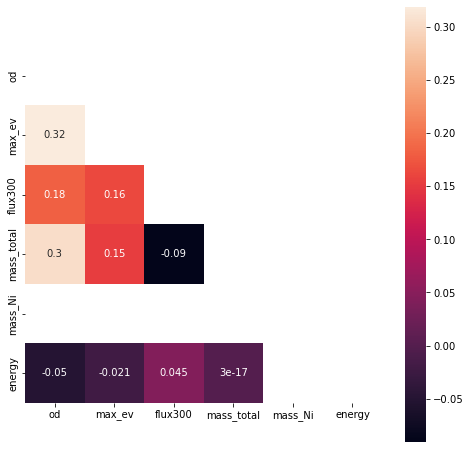

In [25]:
# Test correlation for flux>=<0.4e-5
df[df.flux300<0.4e-5]
corr = df[df.flux300>=1.25e-5].iloc[:,[0,2,4,5,6,7]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,8))
sns.heatmap(corr, mask=mask, square=True, annot=True)
plt.show()

- The pearson correlation between flux and energy has increased by 3 fold. 
- With this in mind, we shall maintain the flux column, and add a column in our input dataset which classifies. 

## 4. Step 3 - Classification
- Steps:
    - 4.1. Feature Engineer / Pre-process Input Features
    - 4.2. Feature Engineer / Pre-process Target Features
    - 4.3. Pre-process all features for classification and regression
    - 4.4. Retest correlation matrix using classification pre-processor - To see improvements
    - 4.5. Create class to upsample dataset
    - 4.6. Choose a scaler

### 4.1. Feature Engineer / Pre-process Input Features

- Recall that we can split the flux column into 4 categories between the following values to create a flux category column: [0, 0.4e-5, 0.85e-5, 1.25e-5, 1.6e-5]
- To add onto that, we can also feature engineer the flux values to indicate its deviation from the mean of its own category. I believe that this will be more valuable to the model since the flux for each category has a higher correlation to energy than the full flux range.

In [26]:
class InputFeaturesPreprocessor:
    """Class object to pre-process the input features dataset.
    Optical density and max expansion velocity columns are left untouched.
    Flux is feature engineered into its nominal category and its deviation from category mean.
    """
    def __init__(self):
        self.fitted = False

    def __get_flux300_category(self, flux):
        if flux<0.4e-5:
            return 0.0
        if flux<0.85e-5:
            return 1.0
        if flux<1.25e-5:
            return 2.0
        if flux<1.6e-5:
            return 3.0
            
    def __get_flux300_categoric_means(self, X):
        self._flux300 = X.flux300
        self._flux300_cat = X.flux300.apply(self.__get_flux300_category)
        self._flux_means = {cat:(self._flux300[self._flux300_cat==cat]).mean() for cat in range(4)}
    
    def __get_flux300_dev_from_mean(self, flux):
        cat = self.__get_flux300_category(flux)
        mean = self._flux_means[cat]
        return mean-flux

    def fit(self, X):
        """Method to fit the dataset classes.
        """
        self.features_names_in_ = list(X.columns)
        self.features_names_out_ = self.features_names_in_+['flux300_cat','flux300_dev']
        self.features_names_out_.remove('flux300')
        self.__get_flux300_categoric_means(X)
        self.fitted = True

    def transform(self, X):
        """Method to transform the dataset.
        """
        if self.fitted:
            transformed = X.copy()
            transformed['flux300_cat'] = transformed.flux300.map(self.__get_flux300_category)
            transformed['flux300_dev'] = transformed.flux300.map(self.__get_flux300_dev_from_mean)
            transformed.drop(['flux300'],axis=1,inplace=True)
            return transformed
        else:
            raise NotFittedError(
                'This preprocessor has yet to be fitted.'
            )
    def fit_transform(self, X):
        """Method to fit and then transform the dataset.
        """
        self.fit(X)
        return self.transform(X)
    
    def __get_flux(self, cat_dev):
        return self._flux_means[cat_dev[0]]-cat_dev[1]

    def inverse_transform(self, X):
        """Method to inversely transform the dataset.
        """
        if type(X)==np.ndarray:
            X = pd.DataFrame(X,columns=self.features_names_out_)
        inv_transform = X.copy()
        inv_transform['flux300'] = inv_transform[['flux300_cat','flux300_dev']].apply(lambda x: self.__get_flux(x), axis=1)
        inv_transform.drop(['flux300_cat','flux300_dev'],axis=1,inplace=True)
        return inv_transform
        

In [27]:
input = df_obs.iloc[:,[0,2,4]]
input.head()

,od,max_ev,flux300
0,1.940628,0.013531,0.000003
1,2.071999,0.012423,0.000003
2,2.007982,0.012744,0.000003
3,1.661535,0.009935,0.000003
4,1.907672,0.013343,0.000003


In [28]:
IFP  = InputFeaturesPreprocessor()
preprocessed_input = IFP.fit_transform(input)
preprocessed_input.head()

,od,max_ev,flux300_cat,flux300_dev
0,1.940628,0.013531,0.0,1.837554e-07
1,2.071999,0.012423,0.0,-7.145215e-08
2,2.007982,0.012744,0.0,-8.485827e-08
3,1.661535,0.009935,0.0,-1.162521e-08
4,1.907672,0.013343,0.0,1.759921e-07


In [29]:
IFP.inverse_transform(preprocessed_input).head()

,od,max_ev,flux300
0,1.940628,0.013531,0.000003
1,2.071999,0.012423,0.000003
2,2.007982,0.012744,0.000003
3,1.661535,0.009935,0.000003
4,1.907672,0.013343,0.000003


### 4.2. Feature Engineer / Pre-process Target Features

In [30]:
class TargetFeaturesPreprocessor:
    """Class object to pre-process the target dataset.
    Performs an ordinal (ordered) encoding for the total mass, nickel mass, energy.
    Performs a nominal (one-hot) encoding for the mass and radial distribution flags.
    """
    def __init__(self):
        self.fitted = False
        pass

    def fit(self,y):
        """Method to fit the dataset classes.
        """
        self._mass_total_map = dict(zip(y.mass_total.unique(),range(len(y.mass_total))))
        self._mass_Ni_map = dict(zip(y.mass_Ni.unique(),range(len(y.mass_Ni))))
        self._energy_map = dict(zip(y.energy.unique(),range(len(y.energy))))
        self._mass_distribution_list = y.mass_distribution.unique()
        self._radial_distribution_list = y.radial_distribution.unique()
        self._enc = OneHotEncoder(categories=[self._mass_distribution_list,self._radial_distribution_list], \
            handle_unknown='ignore')
        self.features_names_in_ = list(y.columns)
        self.features_names_out_ = list(y.columns[:3]) + \
            ['mass_is_'+x for x in self._mass_distribution_list] + \
            ['rad_is_'+x for x in self._radial_distribution_list]
        self.fitted = True
        
    def transform(self,y):
        """Method to transform/encode the dataset.
        """
        if self.fitted:
            y = y.copy()
            y.mass_total = y.mass_total.apply(lambda x: float(self._mass_total_map[x]))
            y.mass_Ni = y.mass_Ni.apply(lambda x: float(self._mass_Ni_map[x]))
            y.energy = y.energy.apply(lambda x: float(self._energy_map[x]))
            dist_df = pd.DataFrame(self._enc.fit_transform(y[['mass_distribution','radial_distribution']]).toarray(), \
                columns=self.features_names_out_[3:])
            y.drop(['mass_distribution','radial_distribution'],axis=1,inplace=True)
            transformed = pd.concat([y,dist_df],axis=1)
            return transformed
        else:
            raise NotFittedError(
                'This preprocessor has yet to be fitted.'
            )
    
    def fit_transform(self,y):
        """Method to fit and then transform the dataset.
        """
        self.fit(y)
        return self.transform(y)
    
    def inverse_transform(self,y):
        """Method to inversely transform the dataset.
        """
        if type(y)==np.ndarray:
            y = pd.DataFrame(y,columns=self.features_names_out_)
        inv_transform = pd.DataFrame()
        dist_df = self._enc.inverse_transform(y.iloc[:,3:])
        inv_mass_total_map = {v: k for k, v in self._mass_total_map.items()}
        inv_mass_Ni_map = {v: k for k, v in self._mass_Ni_map.items()}
        inv_energy_map = {v: k for k, v in self._energy_map.items()}
        inv_transform['mass_total'] = y.mass_total.apply(round).map(inv_mass_total_map)
        inv_transform['mass_Ni'] = y.mass_Ni.apply(round).map(inv_mass_Ni_map)
        inv_transform['energy'] = y.energy.apply(round).map(inv_energy_map)
        inv_transform['mass_distribution'] = dist_df[:,0]
        inv_transform['radial_distribution'] = dist_df[:,1]
        return inv_transform
        


In [31]:
targets = df_phy
targets.head()

,mass_total,mass_Ni,energy,mass_distribution,radial_distribution
0,0.75,0.15,0.75,hed8,hed8
1,0.75,0.15,0.75,hed8,mwd
2,0.75,0.15,0.75,hed8,N100
3,0.75,0.15,0.75,hed8,w7dt
4,0.75,0.15,2.00,hed8,hed8


In [32]:
TFP = TargetFeaturesPreprocessor()
preprocessed_targets = TFP.fit_transform(df_phy)
preprocessed_targets.head()

,mass_total,mass_Ni,energy,mass_is_hed8,mass_is_mwd,mass_is_N100,mass_is_w7dt,rad_is_hed8,rad_is_mwd,rad_is_N100,rad_is_w7dt
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [33]:
TFP.inverse_transform(preprocessed_targets).head()

,mass_total,mass_Ni,energy,mass_distribution,radial_distribution
0,0.75,0.15,0.75,hed8,hed8
1,0.75,0.15,0.75,hed8,mwd
2,0.75,0.15,0.75,hed8,N100
3,0.75,0.15,0.75,hed8,w7dt
4,0.75,0.15,2.00,hed8,hed8


### 4.3 Preprocess dataset
- Here we will create a preprocessor which will create either a dataset for training a classification model or a regression model. 
- We will select the model later

In [34]:
class Preprocessor:
    def __init__(self, mode='classification'):
        self.mode_is_regression = mode=='regression'
        self.IFP = InputFeaturesPreprocessor()
        if self.mode_is_regression:
            self.TFP = TargetFeaturesPreprocessor()

    def fit(self, X, y):
        self.X_features_in = list(X.columns)
        self.y_features_in = list(y.columns)
        self.IFP.fit(X)
        self.X_features_out = self.IFP.features_names_out_
        if self.mode_is_regression:
            self.TFP.fit(y)
            self.y_features_out = self.TFP.features_names_out_
        else:
            self.y_features_out = self.y_features_in

    def transform(self, X, y):
        transformed_X = self.IFP.transform(X)
        if self.mode_is_regression:
            transformed_y = self.TFP.transform(y)
        else:
            transformed_y = y
        return transformed_X, transformed_y
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X, y)
    
    def inverse_transform(self, X, y):
        inv_X = IFP.inverse_transform(X)
        if self.mode_is_regression:
            inv_y = TFP.inverse_transform(y)
        else:
            inv_y = y
        return inv_X, inv_y

Now to test:

In [35]:
X = df.iloc[:,[0,2,4]]
X.head()

,od,max_ev,flux300
0,1.940628,0.013531,0.000003
1,2.071999,0.012423,0.000003
2,2.007982,0.012744,0.000003
3,1.661535,0.009935,0.000003
4,1.907672,0.013343,0.000003


In [36]:
y = df.iloc[:,5:]
y.head()

,mass_total,mass_Ni,energy,mass_distribution,radial_distribution
0,0.75,0.15,0.75,hed8,hed8
1,0.75,0.15,0.75,hed8,mwd
2,0.75,0.15,0.75,hed8,N100
3,0.75,0.15,0.75,hed8,w7dt
4,0.75,0.15,2.00,hed8,hed8


In [37]:
P = Preprocessor(mode='classification')
transformed_X, transformed_y = P.fit_transform(X,y)

In [38]:
transformed_X.head()

,od,max_ev,flux300_cat,flux300_dev
0,1.940628,0.013531,0.0,1.837554e-07
1,2.071999,0.012423,0.0,-7.145215e-08
2,2.007982,0.012744,0.0,-8.485827e-08
3,1.661535,0.009935,0.0,-1.162521e-08
4,1.907672,0.013343,0.0,1.759921e-07


In [39]:
transformed_y.head()

,mass_total,mass_Ni,energy,mass_distribution,radial_distribution
0,0.75,0.15,0.75,hed8,hed8
1,0.75,0.15,0.75,hed8,mwd
2,0.75,0.15,0.75,hed8,N100
3,0.75,0.15,0.75,hed8,w7dt
4,0.75,0.15,2.00,hed8,hed8


### 4.4. Retest correlation matrix using regression preprocessor
- Lets regenerate the correlation matrix to see if we get better correlation between our input and target features.
    - Specifically, kinetic energy previously had low correlation to any observable parameter.

In [40]:
preprocessed_df = pd.concat([preprocessed_input,preprocessed_targets],axis=1)

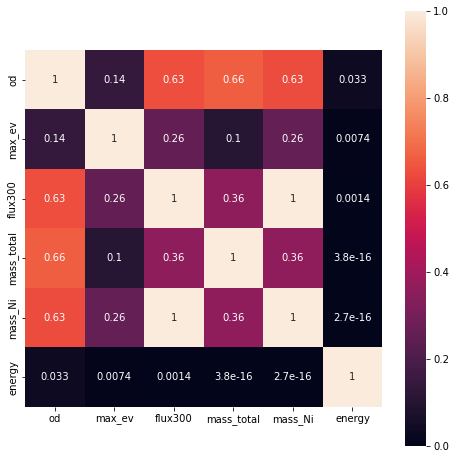

In [41]:
# Initial correlation matrix
corr = abs(df.iloc[:,[0,2,4,5,6,7]].corr())
plt.figure(figsize=(8,8))
sns.heatmap(corr, square=True, annot=True)
plt.show()

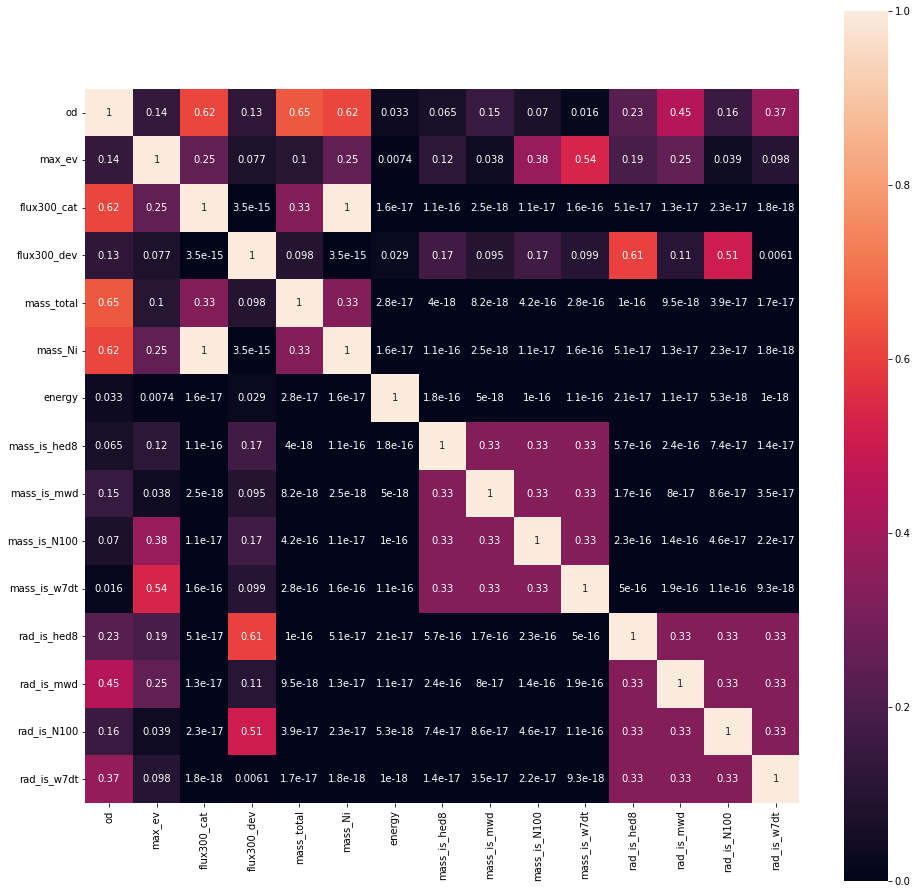

In [42]:
# Correlation matrix after feature engineering
corr = abs(preprocessed_df.corr())
plt.figure(figsize=(16,16))
sns.heatmap(corr, square=True, annot=True)
plt.show()

- From our initial correlation matrix, flux had an absolute correlation of 0.0014 to energy.
- After feature engineering flux deviation, it had and absolute correlation of 0.029 correlation to energy.

### 4.5. Create class to upsample dataset

- Since our dataset came with uncertainties for optical depth and maximum expansion velocity, we can use these uncertainties to upsample our training dataset to accomodate for these uncertainties.
- The definition of uncertainty is unclear in the problem statement. Therefore, we shall make an assumption that an uncertainty value sets a bounding range for the measured value. 
    - ie. estimated optical_depth = 2.0, and uncertainty = 0.5, then actual optical_depth is between 1.5 and 2.5.
- Using the uncertainties, we shall use a random number generator to generate numbers between the possible range of values for each data point. 

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   od                   512 non-null    float64
 1   od_uncertainty       512 non-null    float64
 2   max_ev               512 non-null    float64
 3   max_ev_uncertainty   512 non-null    float64
 4   flux300              512 non-null    float64
 5   mass_total           512 non-null    float64
 6   mass_Ni              512 non-null    float64
 7   energy               512 non-null    float64
 8   mass_distribution    512 non-null    object 
 9   radial_distribution  512 non-null    object 
dtypes: float64(8), object(2)
memory usage: 40.1+ KB


- The original dataset has 512 rows, lets create a custom class to resample our data to 100,000 rows.

In [44]:
class Resampler:
    def __init__(self, random_seed=0):
        seed(random_seed)

    def __random_value_generator(self, value_uncertainty):
        value, uncertainty = value_uncertainty
        _min = value-uncertainty
        _range = 2*uncertainty
        value = _min + _range*random()
        return value

    def upsample(self, df, n_samples):
        """Method to upsample the dataset.
        For rows more than the original dataset, random values are generated according to the range of its uncertainty.
        """
        self.n_samples = n_samples
        assert n_samples>=len(df), "n_samples must be greater than length of input dataframe."
        n_generate = n_samples-len(df)
        resampled_df = resample(df, n_samples=n_generate)
        resampled_df['od'] = resampled_df[['od','od_uncertainty']].apply(self.__random_value_generator, axis=1)
        resampled_df['max_ev'] = resampled_df[['max_ev','max_ev_uncertainty']].apply(self.__random_value_generator, axis=1)
        resampled_df = pd.concat([df,resampled_df],axis=0)
        resampled_df.drop(['od_uncertainty','max_ev_uncertainty'], axis=1, inplace=True)
        return resampled_df

In [45]:
RS = Resampler()
resampled_df = RS.upsample(df,n_samples=100000)
resampled_df

,od,max_ev,flux300,mass_total,mass_Ni,energy,mass_distribution,radial_distribution
0,1.940628,0.013531,0.000003,0.75,0.15,0.75,hed8,hed8
1,2.071999,0.012423,0.000003,0.75,0.15,0.75,hed8,mwd
2,2.007982,0.012744,0.000003,0.75,0.15,0.75,hed8,N100
3,1.661535,0.009935,0.000003,0.75,0.15,0.75,hed8,w7dt
4,1.907672,0.013343,0.000003,0.75,0.15,2.00,hed8,hed8
...,...,...,...,...,...,...,...,...
371,2.619326,0.013776,0.000011,2.00,0.60,0.75,N100,w7dt
388,2.023539,0.013136,0.000003,0.75,0.15,2.00,w7dt,hed8
262,2.059638,0.011703,0.000003,0.75,0.15,2.00,N100,N100
115,2.552258,0.013248,0.000011,2.00,0.60,0.75,hed8,w7dt


In [46]:
# Get resampled data created by the first original values
resampled_df.loc[0].head()

,od,max_ev,flux300,mass_total,mass_Ni,energy,mass_distribution,radial_distribution
0,1.940628,0.013531,0.000003,0.75,0.15,0.75,hed8,hed8
0,1.909784,0.013854,0.000003,0.75,0.15,0.75,hed8,hed8
0,2.025313,0.013812,0.000003,0.75,0.15,0.75,hed8,hed8
0,2.005491,0.014071,0.000003,0.75,0.15,0.75,hed8,hed8
0,2.007150,0.013324,0.000003,0.75,0.15,0.75,hed8,hed8


- The first row in the above dataframs is the from the original dataset,
- The following lines are created at random based on the uncertainty values for columns "od" and "max_ev".

In [47]:
for col in resampled_df.loc[:,'mass_total':].columns:
    print(resampled_df[col].value_counts())

1.80    25138
2.00    25065
1.40    24791
1.00    12507
0.75    12499
Name: mass_total, dtype: int64
0.15    31245
0.30    31093
0.75    18959
0.60    18703
Name: mass_Ni, dtype: int64
0.75    50129
2.00    49871
Name: energy, dtype: int64
w7dt    25213
mwd     24963
N100    24955
hed8    24869
Name: mass_distribution, dtype: int64
N100    25051
w7dt    25014
mwd     24989
hed8    24946
Name: radial_distribution, dtype: int64


- Note that for our target features, we have some class imbalance for the total mass and nickel mass. However, this could be improved by resampling based on class counts, however, I will not be doing this for this evaluation.

### 4.6. Select scaler
- Lets test out a Min-Max scaler, which should scale our data to values 0 to 1. This should work well as we do not seem to have any columns with extreme outliers.

In [48]:
scaler = MinMaxScaler()
scaled_preprocessed_data = scaler.fit_transform(preprocessed_df)
scaled_preprocessed_data[0]

array([0.14236338, 0.75565508, 0.        , 0.58125093, 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ])

## 5. Model Pipeline and Metrics

- 5.1. Upsample dataset
- 5.2. Pre-process data
- 5.3. Scaling
- 5.4. Model selection & Cross Validation Metrics

### 5.1. Upsample Dataset

In [49]:
R = Resampler()
upsampled_df = R.upsample(df, n_samples=100000)
print(f'Data has been upsampled from {len(df)} rows to {R.n_samples} rows.')
X = upsampled_df[['od','max_ev','flux300']]
y = upsampled_df[['mass_total','mass_Ni','energy','mass_distribution','radial_distribution']]
print('X:\n',X.head())
print('y:\n',y.head())


Data has been upsampled from 512 rows to 100000 rows.
X:
          od    max_ev   flux300
0  1.940628  0.013531  0.000003
1  2.071999  0.012423  0.000003
2  2.007982  0.012744  0.000003
3  1.661535  0.009935  0.000003
4  1.907672  0.013343  0.000003
y:
    mass_total  mass_Ni  energy mass_distribution radial_distribution
0        0.75     0.15    0.75              hed8                hed8
1        0.75     0.15    0.75              hed8                 mwd
2        0.75     0.15    0.75              hed8                N100
3        0.75     0.15    0.75              hed8                w7dt
4        0.75     0.15    2.00              hed8                hed8


### 5.2. Pre-process data

In [50]:
preprocessor = Preprocessor(mode='classification')
X, y = preprocessor.fit_transform(X, y)
print('X:\n',X.head())
print('y:\n',y.head())


X:
          od    max_ev  flux300_cat   flux300_dev
0  1.940628  0.013531          0.0  1.836436e-07
1  2.071999  0.012423          0.0 -7.156399e-08
2  2.007982  0.012744          0.0 -8.497011e-08
3  1.661535  0.009935          0.0 -1.173705e-08
4  1.907672  0.013343          0.0  1.758803e-07
y:
    mass_total  mass_Ni  energy mass_distribution radial_distribution
0        0.75     0.15    0.75              hed8                hed8
1        0.75     0.15    0.75              hed8                 mwd
2        0.75     0.15    0.75              hed8                N100
3        0.75     0.15    0.75              hed8                w7dt
4        0.75     0.15    2.00              hed8                hed8


### 5.3. Scaling

In [51]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
print('X:\n',X[:5])


X:
 [[0.19572453 0.70083771 0.         0.57987551]
 [0.25124824 0.51075806 0.         0.42006559]
 [0.22419126 0.56587346 0.         0.41167073]
 [0.07776643 0.08385602 0.         0.45752897]
 [0.18179547 0.66861302 0.         0.57501418]]


In [52]:
y = y.astype(str).values
print('y:\n',y[:5])

y:
 [['0.75' '0.15' '0.75' 'hed8' 'hed8']
 ['0.75' '0.15' '0.75' 'hed8' 'mwd']
 ['0.75' '0.15' '0.75' 'hed8' 'N100']
 ['0.75' '0.15' '0.75' 'hed8' 'w7dt']
 ['0.75' '0.15' '2.0' 'hed8' 'hed8']]


### 5.4. Model selection & Cross Validation Metrics

- Lets try using a random forest classifier.
- We can use its default parameters as a baseline and see how it performs.
- The random forest classifier's default metric is class mean accuracy, this should be enough to get a clear idea of how well our model performs.

In [53]:
# Model selection
clf = RandomForestClassifier(n_jobs=16)
# For multi-output
multi_clf = MultiOutputClassifier(clf,n_jobs=16)
multi_clf

MultiOutputClassifier(estimator=RandomForestClassifier(n_jobs=16), n_jobs=16)

In [54]:
# Cross validation scoring
scoring = ['accuracy','precision','recall','f1_macro','f1_samples']
scores = cross_val_score(multi_clf, X, y, cv=5)
scores

array([0.9957 , 0.99465, 0.99445, 0.99355, 0.9945 ])

In [55]:
print(f'With a 5-fold cross-validation, we have obtained a mean class \
accuracy of {scores.mean()} with a standard deviation of {scores.std()}.')

With a 5-fold cross-validation, we have obtained a mean class accuracy of 0.9945700000000001 with a standard deviation of 0.0006845436436049915.


- We have obtained very good results (99.46% mean accuracy) for our baseline classifier and therefore shall not improve on it further.
- However, lets retrain on the full set of data prior to performing inference on the test cases.

## 6. Test Cases

- Before performing a prediction on the 3 test cases, lets train on the full model.

In [56]:
# Train/fit on full dataset
multi_clf.fit(X,y)

MultiOutputClassifier(estimator=RandomForestClassifier(n_jobs=16), n_jobs=16)

In [57]:
# Prepare the test case inputs for inference
def prep_test_input(od, max_ev, flux300, fitted_preprocessor, fitted_scaler):
    """Function to perform preprocessing and scaling on the test cases
    """
    test_case = pd.DataFrame([[od,max_ev,flux300]], columns=fitted_preprocessor.X_features_in)
    test_case, _ = fitted_preprocessor.transform(X=test_case, y=None)
    test_case = fitted_scaler.transform(test_case)
    return test_case

# Test case 1
test_case_1 = [3.35,0.015,1.20e-5]
test_case_1_processed = prep_test_input(*test_case_1, 
    fitted_preprocessor=preprocessor,
    fitted_scaler=scaler)
print(test_case_1,'-->',test_case_1_processed)

# Test case 2
test_case_2 = [2.54,0.013,5.02e-6]
test_case_2_processed = prep_test_input(*test_case_2, 
    fitted_preprocessor=preprocessor,
    fitted_scaler=scaler)
print(test_case_2,'-->',test_case_2_processed)

# Test case 3
test_case_3 = [2.46,0.013,1.03e-5]
test_case_3_processed = prep_test_input(*test_case_3, 
    fitted_preprocessor=preprocessor,
    fitted_scaler=scaler)
print(test_case_3,'-->',test_case_3_processed)

[3.35, 0.015, 1.2e-05] --> [[0.79139237 0.95296311 0.66666667 0.06670807]]
[2.54, 0.013, 5.02e-06] --> [[0.44904768 0.60980161 0.33333333 0.93216011]]
[2.46, 0.013, 1.03e-05] --> [[0.41523585 0.60980161 0.66666667 1.13124102]]


In [58]:
def display_prediction(input, results, units):
    """Function to print the inference results."""
    print('Observable/Input Parameters:')
    print(f'\tOptical depth = {input[0]}')
    print(f'\tMax. Expansion Velocity = {input[1]} {units["max_ev"]}')
    print(f'\tEmergent SNela Flex = {input[2]} {units["flux300"]}')
    
    results = results[0]
    print('Predicted Physical Parameters:')
    print(f'\tTotal Mass = {results[0]} {units["mass_total"]}')
    print(f'\tNickle Mass = {results[1]} {units["mass_Ni"]}')
    print(f'\tExplosion Energy = {results[2]} {units["energy"]}')
    print(f'\tInitial SNela mass distribution flag = {results[3]}')
    print(f'\tInitial Nickle mass distribution flag = {results[4]}')

In [59]:
print('TEST CASE 1')
display_prediction(test_case_1, multi_clf.predict(test_case_1_processed), units)

TEST CASE 1
Observable/Input Parameters:
	Optical depth = 3.35
	Max. Expansion Velocity = 0.015 s⁻¹
	Emergent SNela Flex = 1.2e-05 cm⁻²s⁻¹
Predicted Physical Parameters:
	Total Mass = 1.8 M☉
	Nickle Mass = 0.6 M☉
	Explosion Energy = 2.0 10⁵¹ ergs
	Initial SNela mass distribution flag = N100
	Initial Nickle mass distribution flag = N100


In [60]:
print('\nTEST CASE 2')
display_prediction(test_case_2, multi_clf.predict(test_case_2_processed), units)


TEST CASE 2
Observable/Input Parameters:
	Optical depth = 2.54
	Max. Expansion Velocity = 0.013 s⁻¹
	Emergent SNela Flex = 5.02e-06 cm⁻²s⁻¹
Predicted Physical Parameters:
	Total Mass = 2.0 M☉
	Nickle Mass = 0.3 M☉
	Explosion Energy = 2.0 10⁵¹ ergs
	Initial SNela mass distribution flag = hed8
	Initial Nickle mass distribution flag = hed8


In [61]:
print('\nTEST CASE 3')
display_prediction(test_case_3, multi_clf.predict(test_case_3_processed), units)


TEST CASE 3
Observable/Input Parameters:
	Optical depth = 2.46
	Max. Expansion Velocity = 0.013 s⁻¹
	Emergent SNela Flex = 1.03e-05 cm⁻²s⁻¹
Predicted Physical Parameters:
	Total Mass = 1.4 M☉
	Nickle Mass = 0.6 M☉
	Explosion Energy = 2.0 10⁵¹ ergs
	Initial SNela mass distribution flag = hed8
	Initial Nickle mass distribution flag = hed8


- Notes on pipeline:
    - for a production pipeline, the user requirements will need to be understood.
    - inference speed is fast, but can be improved via usage of other models. 
    - model performance (99.4% accuracy) is good, but can be improved via usage of other models as well.